<a href="https://colab.research.google.com/github/philBram/tensorflow/blob/main/food_101_dataset_conv_net_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hansgntermayer","key":"5396338d1f2e946610e16e17106b13de"}'}

In [3]:
import os.path

if not os.path.exists('../root/.kaggle'):
  !mkdir ~/.kaggle
  !mv kaggle.json ~/.kaggle
  !chmod 600 ~/.kaggle/kaggle.json

In [4]:
if not os.path.exists('food41.zip'):
  !kaggle datasets download kmader/food41
  !unzip -qo food41.zip -d food41

Dataset URL: https://www.kaggle.com/datasets/kmader/food41
License(s): copyright-authors
100% 5.30G/5.30G [03:50<00:00, 25.7MB/s]
100% 5.30G/5.30G [03:50<00:00, 24.6MB/s]


In [5]:
for root, dirs, files in os.walk('food41'):
  print(f'{len(dirs)} dirictories and {len(files)} files in "{root}"')

2 dirictories and 11 files in "food41"
1 dirictories and 0 files in "food41/meta"
0 dirictories and 6 files in "food41/meta/meta"
101 dirictories and 0 files in "food41/images"
0 dirictories and 1000 files in "food41/images/mussels"
0 dirictories and 1000 files in "food41/images/chicken_wings"
0 dirictories and 1000 files in "food41/images/prime_rib"
0 dirictories and 1000 files in "food41/images/pad_thai"
0 dirictories and 1000 files in "food41/images/bread_pudding"
0 dirictories and 1000 files in "food41/images/fish_and_chips"
0 dirictories and 1000 files in "food41/images/tacos"
0 dirictories and 1000 files in "food41/images/fried_calamari"
0 dirictories and 1000 files in "food41/images/french_onion_soup"
0 dirictories and 1000 files in "food41/images/cup_cakes"
0 dirictories and 1000 files in "food41/images/filet_mignon"
0 dirictories and 1000 files in "food41/images/crab_cakes"
0 dirictories and 1000 files in "food41/images/frozen_yogurt"
0 dirictories and 1000 files in "food41/im

In [19]:
!ls food41/images/fried_rice | head

1004221.jpg
1008935.jpg
1015700.jpg
1019981.jpg
1021229.jpg
1022515.jpg
1023430.jpg
1028159.jpg
1028939.jpg
1042399.jpg


In [6]:
!ls -la food41/meta/meta

total 4148
drwxr-xr-x 2 root root    4096 May 11 00:48 .
drwxr-xr-x 3 root root    4096 May 11 00:48 ..
-rw-r--r-- 1 root root    1184 Sep 20  2019 classes.txt
-rw-r--r-- 1 root root    1184 Sep 20  2019 labels.txt
-rw-r--r-- 1 root root  566868 Sep 20  2019 test.json
-rw-r--r-- 1 root root  489429 Sep 20  2019 test.txt
-rw-r--r-- 1 root root 1697751 Sep 20  2019 train.json
-rw-r--r-- 1 root root 1468812 Sep 20  2019 train.txt


In [8]:
import json

def get_labels(label_path):

  with open(label_path) as f:
    return json.load(f)

train_labels = get_labels('food41/meta/meta/train.json')
test_labels = get_labels('food41/meta/meta/test.json')

In [16]:
list(train_labels.keys())[:10]

['churros',
 'hot_and_sour_soup',
 'samosa',
 'sashimi',
 'pork_chop',
 'spring_rolls',
 'panna_cotta',
 'beef_tartare',
 'greek_salad',
 'foie_gras']

In [21]:
train_labels['fried_rice'][:10]

['fried_rice/1004221',
 'fried_rice/1008935',
 'fried_rice/1015700',
 'fried_rice/1019981',
 'fried_rice/1021229',
 'fried_rice/1022515',
 'fried_rice/1043851',
 'fried_rice/1052689',
 'fried_rice/1053345',
 'fried_rice/1059042']

In [25]:
len(train_labels['fried_rice']), len(test_labels['fried_rice'])

(750, 250)

In [42]:
def create_dir_structure(first_class, second_class):
  root_dir = 'food-101'

  train_dir = os.path.join(root_dir, 'train')
  test_dir = os.path.join(root_dir, 'test')

  first_class_train_dir = os.path.join(train_dir, first_class)
  first_class_test_dir = os.path.join(test_dir, first_class)

  second_class_train_dir = os.path.join(train_dir, second_class)
  second_class_test_dir = os.path.join(test_dir, second_class)

  if not os.path.exists('food-101'):
    os.makedirs(first_class_train_dir)
    os.makedirs(first_class_test_dir)
    os.makedirs(second_class_train_dir)
    os.makedirs(second_class_test_dir)

In [54]:
first_class = 'fried_rice'
second_class = 'french_fries'

create_dir_structure(first_class, second_class)

In [55]:
for root, dirs, files in os.walk('food-101'):
  print(f'{len(dirs)} dirictories and {len(files)} files in "{root}"')

2 dirictories and 0 files in "food-101"
2 dirictories and 0 files in "food-101/test"
0 dirictories and 250 files in "food-101/test/french_fries"
0 dirictories and 250 files in "food-101/test/fried_rice"
2 dirictories and 0 files in "food-101/train"
0 dirictories and 750 files in "food-101/train/french_fries"
0 dirictories and 750 files in "food-101/train/fried_rice"


In [48]:
import shutil

def copy_images(labels, method):
  first_class_labels = labels[first_class]
  second_class_labels = labels[second_class]

  src_dir = f'food41/images/'
  dest_dir = 'food-101/train' if method == 'train' else 'food-101/test'

  for label in np.hstack([first_class_labels, second_class_labels]):

    shutil.copy(os.path.join(src_dir, label + '.jpg'), os.path.join(dest_dir, label + '.jpg'))

In [49]:
copy_images(train_labels, 'train')
copy_images(test_labels, 'test')

In [56]:
for root, dirs, files in os.walk('food-101'):
  print(f'{len(dirs)} dirictories and {len(files)} files in "{root}"')

2 dirictories and 0 files in "food-101"
2 dirictories and 0 files in "food-101/test"
0 dirictories and 250 files in "food-101/test/french_fries"
0 dirictories and 250 files in "food-101/test/fried_rice"
2 dirictories and 0 files in "food-101/train"
0 dirictories and 750 files in "food-101/train/french_fries"
0 dirictories and 750 files in "food-101/train/fried_rice"


In [63]:
import cv2

def plot_random_images(row=3, col=3, train_data=True):

  dir_name = 'food-101/train/' if train_data else 'food-101/test/'

  fig, ax = plt.subplots(row, col, figsize=(10, 8))
  fig.suptitle('train images', fontsize=18) if train_data else fig.suptitle('test images', fontsize=18)

  first_class_images_path = [os.path.join(dir_name, first_class, img_path) for img_path in os.listdir(dir_name + first_class)]
  second_class_images_path = [os.path.join(dir_name, second_class, img_path) for img_path in os.listdir(dir_name + second_class)]

  images_path = np.hstack([first_class_images_path, second_class_images_path])

  random_image_choices = np.random.choice(images_path, row * col, replace=False)

  for i in range(row * col):
    i_index = i // col
    j_index = i % col

    image = cv2.imread(random_image_choices[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax[i_index, j_index].axis('off')
    ax[i_index, j_index].set_title(first_class if first_class in random_image_choices[i] else second_class)
    ax[i_index, j_index].imshow(image)

  plt.tight_layout()
  plt.show()

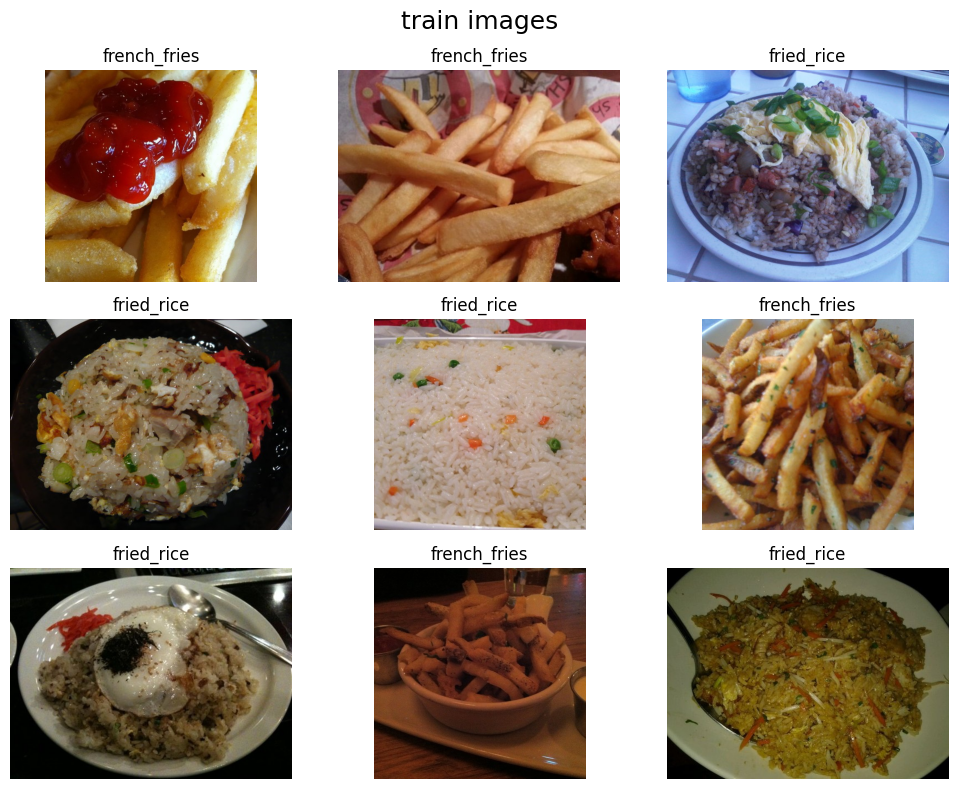

In [64]:
plot_random_images()